In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import TransferFunctionModel
from Model.back_prop_utils import H_th_function, round_to_sig_figs, c
from Model.plotting_utils import plot_transfer, plot_comparison, plot_loss_contributions

In [2]:
## Move file directory to import Extractor for signal manipulation
# Save the original sys.path
original_sys_path = sys.path.copy()

try:
    # Move two levels up to THz-TDS and add it to sys.path
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

    # Now import Extractor
    from Extraction.Extractor import Extractor

finally:
    # Restore sys.path to its original state
    sys.path = original_sys_path

In [3]:
# Define file paths within THz-TDS repo
ref_path = "../../Data_sets/simple_data/ref.pulse.csv"
sample_path = "../../Data_sets/simple_data/Si.pulse.csv"

# Load data 
ref = pd.read_csv(ref_path).to_numpy()
sample = pd.read_csv(sample_path).to_numpy()

In [4]:
print("Reference shape:", ref.shape)
print("Sample shape:", sample.shape)

Reference shape: (701, 2)
Sample shape: (701, 2)


In [5]:
extractor = Extractor(ref, sample, thickness=3*1e-3)

Reference:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -37.46477718688622
Mean squared error:  0.0671512209065479
(Should be ~< 1.)
--------------------
Sample:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -192.24418598426507
Mean squared error:  0.06413903301303736
(Should be ~< 1.)
--------------------
Transfer function:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -154.77940879737844
Mean squared error:  6.112181585650803e-05
(Should be ~< 1.)
--------------------


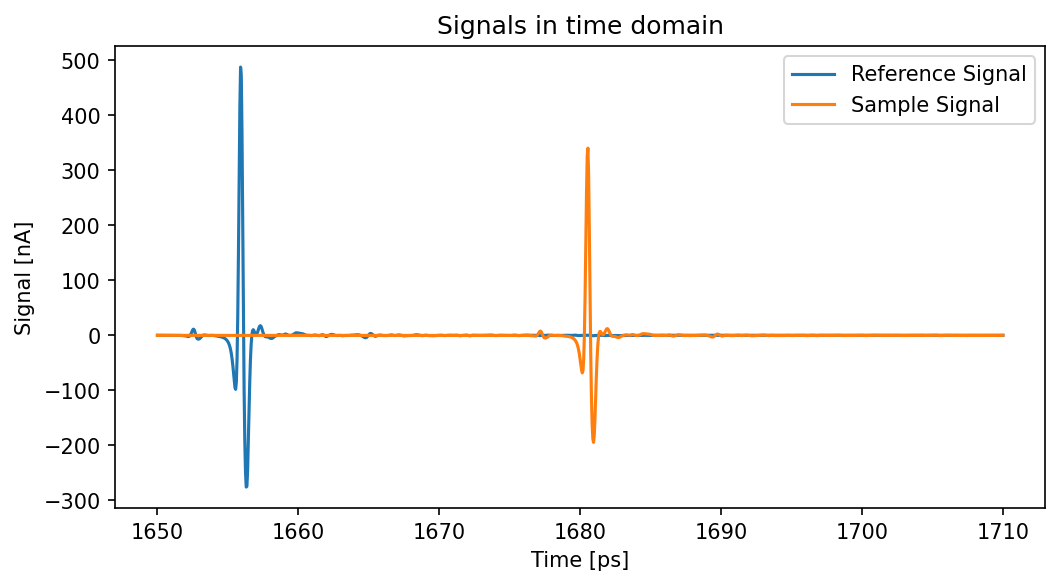

In [6]:
extractor.plot_time_domain()

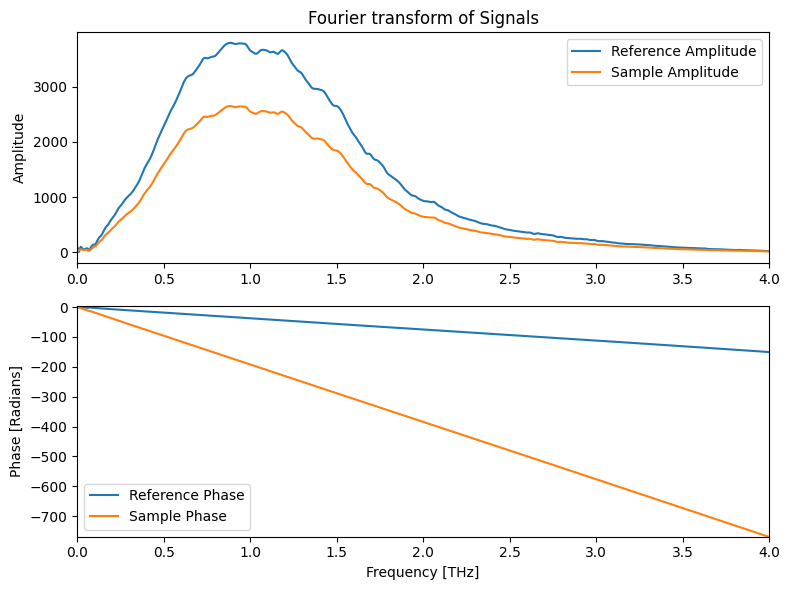

In [7]:
extractor.plot_frequency_domain(x_lims=[0,4])

In [8]:
df = extractor.get_fft_data()
df

,interpolated frequency,amplitude_signal_ref,amplitude_signal_sample,phase_signal_ref,phase_signal_sample,amplitude_transfer,phase_transfer,fast_n
0,0.000000,95.148531,15.572690,-0.429684,2.716322,0.163667,-3.137179,9.405027e+24
1,0.004880,69.694027,23.909452,-1.262713,0.623413,0.343063,-4.397059,1.533071e+01
2,0.009760,6.948951,37.244900,-1.993110,-0.880350,5.359788,-5.170426,9.425614e+00
3,0.014640,60.338845,47.704227,0.215530,-2.192593,0.790606,-2.408124,3.616151e+00
4,0.019520,98.849323,53.157152,-0.549669,-3.419308,0.537759,-2.869639,3.338151e+00
...,...,...,...,...,...,...,...,...
4091,19.963827,94.167196,53.476666,-2179.898373,-5123.353733,0.567891,-2956.021730,3.354959e+00
4092,19.968707,98.849323,53.157152,-2180.575001,-5124.510444,0.537759,-2956.501814,3.354766e+00
4093,19.973587,60.338845,47.704227,-2181.340200,-5125.737159,0.790606,-2956.963329,3.354558e+00
4094,19.978467,6.948951,37.244900,-2179.131560,-5127.049402,5.359788,-2954.201027,3.351784e+00


In [9]:
# Define frequency range we are interested in.
freqs_range = [0.3, 2]

freqs_THz = df['interpolated frequency']

# Find the closest available values within the range
lower_bound = freqs_THz[freqs_THz >= freqs_range[0]].min()
upper_bound = freqs_THz[freqs_THz <= freqs_range[1]].max()

# Apply the boundaries
# Ensure df['frequency'] exists and corresponds to freqs_THz
df_filtered = df[(df['interpolated frequency'] >= lower_bound) & (df['interpolated frequency'] <= upper_bound)]
freqs_THz = freqs_THz[(freqs_THz >= lower_bound) & (freqs_THz <= upper_bound)]

H_values = df_filtered['amplitude_transfer']
phi_values = df_filtered['phase_transfer'] 

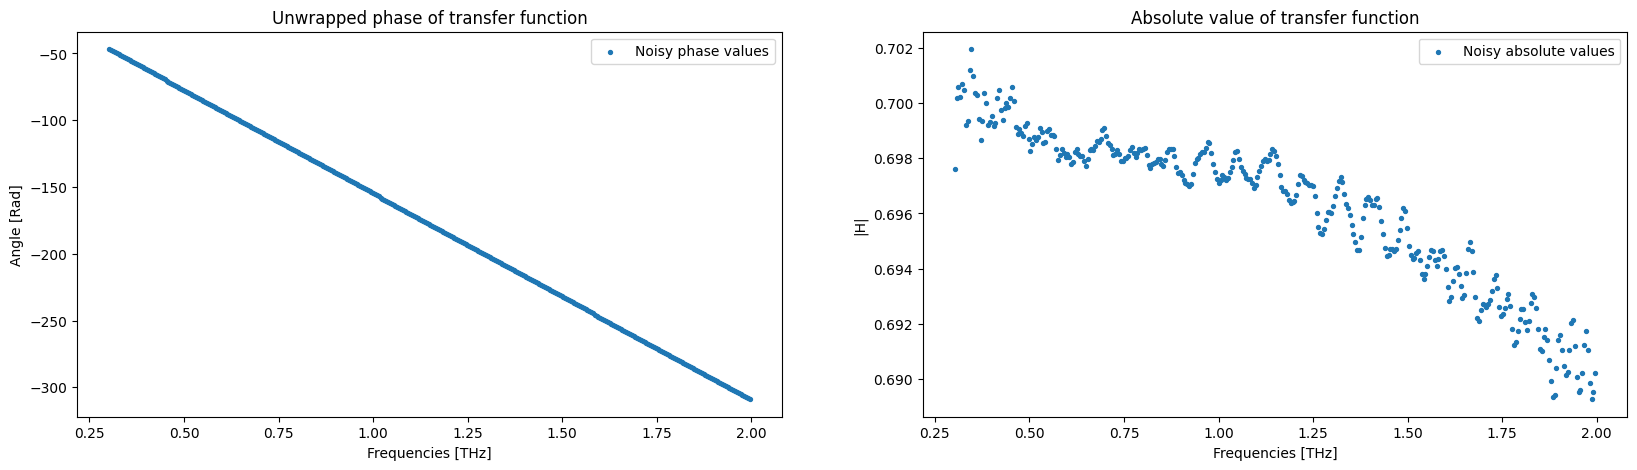

In [10]:
plot_transfer(freqs_THz, H_values, phi_values)

In [11]:
## Use model to fit the experimental data
import Model.loss_functions


thickness = 3*1e-3
f = freqs_THz.to_numpy()

# Convert f_tensor to angular freqs with correct scale for predictions
f = f * (1 * 1e12)
w_tensor = f * np.pi * 2

# Convert correct values to tensor
w_tensor = torch.tensor(w_tensor, dtype=torch.float32)
H_values = torch.tensor(H_values.to_numpy(), dtype=torch.float32)
phi_values = torch.tensor(phi_values.to_numpy(), dtype=torch.float32)
loss = Model.loss_functions.loss

# Initialize model for frequency range, thickness and initial conditions
model = TransferFunctionModel(w_tensor=w_tensor,d=thickness, ICs=[3.2, -0.001])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=500
        )

# Perform optimization
model.train_model(loss_fn=loss, optimizer=optimizer, scheduler=scheduler, H_values=H_values, phi_values=phi_values)

# Access best parameters after training
print(f"Best Parameters: n = {model.best_params['n']}, k = {model.best_params['k']}")

# Plot training curves
model.plot_training_curves()

Epoch 0: Total Loss = 18.25275421142578, Learning Rate = 0.001
Epoch 500: Total Loss = 4.570432186126709, Learning Rate = 0.001
Epoch 1000: Total Loss = 3.3780977725982666, Learning Rate = 0.001
Epoch 1500: Total Loss = 3.3515849113464355, Learning Rate = 0.001
Epoch 2000: Total Loss = 3.4087398052215576, Learning Rate = 0.001
Epoch 2500: Total Loss = 3.479942560195923, Learning Rate = 0.0001
Epoch 3000: Total Loss = 3.506938934326172, Learning Rate = 1e-05
Epoch 3500: Total Loss = 3.510035276412964, Learning Rate = 1.0000000000000002e-06
Epoch 4000: Total Loss = 3.510035276412964, Learning Rate = 1.0000000000000002e-07
Epoch 4500: Total Loss = 3.510035276412964, Learning Rate = 1.0000000000000004e-08
Epoch 5000: Total Loss = 3.510035276412964, Learning Rate = 1.0000000000000004e-08
Epoch 5500: Total Loss = 3.510035276412964, Learning Rate = 1.0000000000000004e-08
Epoch 6000: Total Loss = 3.510035276412964, Learning Rate = 1.0000000000000004e-08
Epoch 6500: Total Loss = 3.5100352764129

TypeError: plot_training_progress() takes from 1 to 4 positional arguments but 6 were given

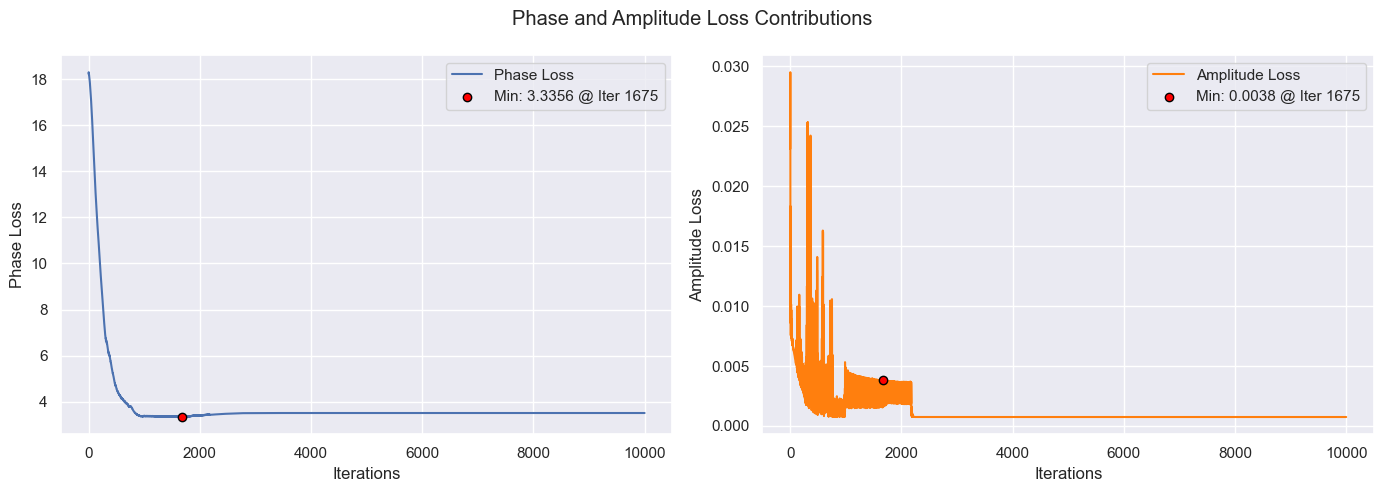

In [12]:
plot_loss_contributions(model.phase_loss_history, model.abs_loss_history)

In [13]:
optimal_complex_n = model.best_params['n'] + 1j*model.best_params['k']
optimal_complex_n

(3.40524959564209-0.00018711460870690644j)

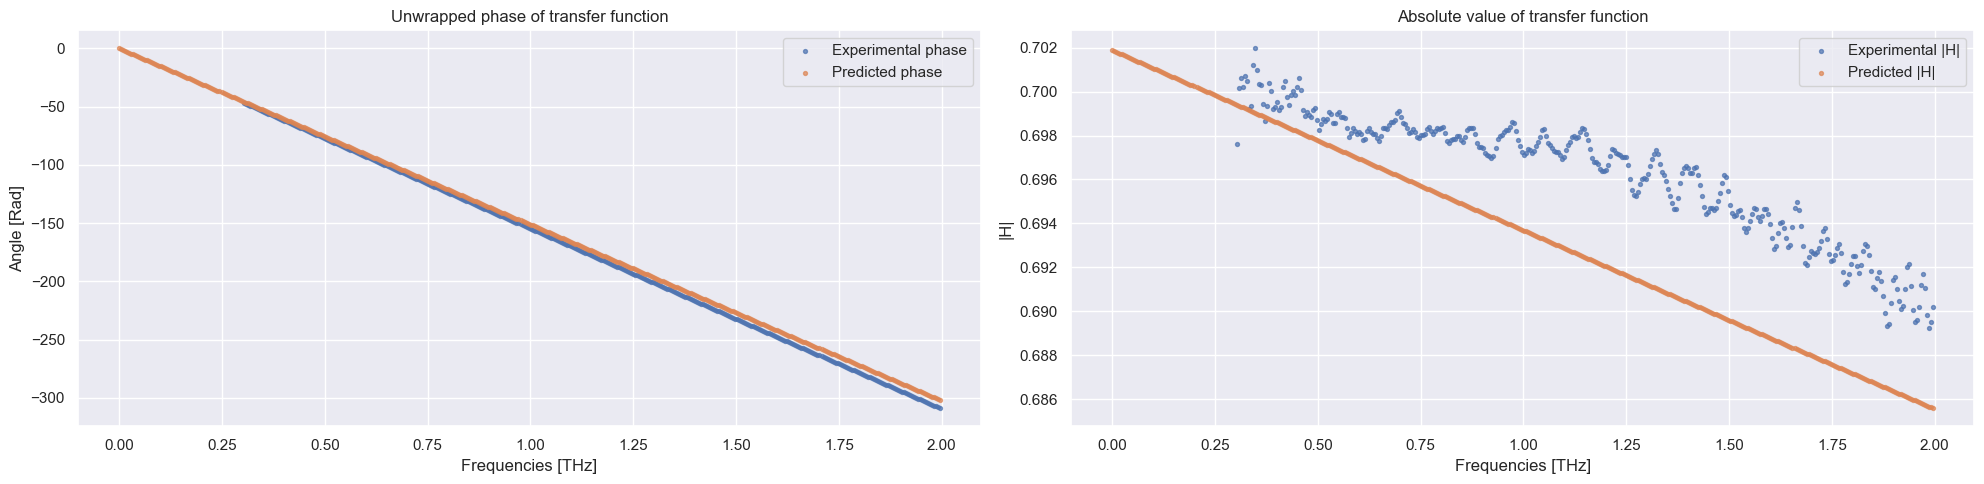

In [14]:
# Create extended array of frequencies
extended_freqs = model.full_w_tensor
extended_freqs = extended_freqs[:-1]

# Get extended THz freqs
extended_freqs_plot = df['interpolated frequency']
extended_freqs_plot = extended_freqs_plot[extended_freqs_plot <= upper_bound].to_numpy()

extended_freqs_plot = torch.tensor(extended_freqs_plot, dtype=torch.float32)

extended_H = H_th_function(optimal_complex_n, w=extended_freqs, length=3*1e-3)

extended_abs = torch.abs(extended_H)
extended_phase = torch.angle(extended_H)

extended_phi = np.unwrap(extended_phase.numpy())
extended_phi = torch.tensor(extended_phi, dtype=torch.float32)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot phase values
axs[0].scatter(freqs_THz, phi_values, s=8, label='Experimental phase', alpha=0.7)
axs[0].scatter(extended_freqs_plot, extended_phi, s=8, label='Predicted phase', alpha=0.7)
axs[0].set_title('Unwrapped phase of transfer function')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')
axs[0].legend()

# Plot absolute values
axs[1].scatter(freqs_THz, H_values, s=8, label='Experimental |H|', alpha=0.7)
axs[1].scatter(extended_freqs_plot, extended_abs, s=8, label='Predicted |H|', alpha=0.7)
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')
axs[1].legend()

plt.tight_layout()
plt.show()

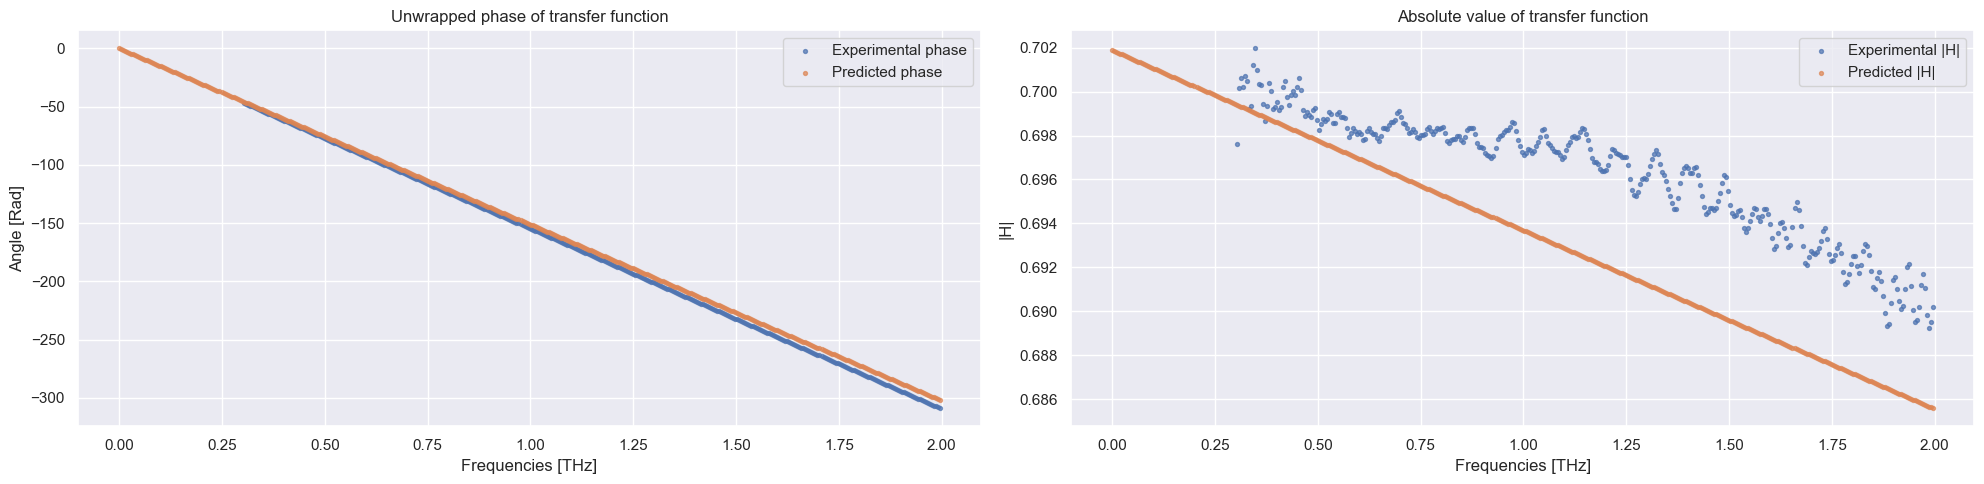

In [15]:
# TODO: Plot data in region we are interested in [0.3, 2]THz

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot phase values
axs[0].scatter(freqs_THz, phi_values, s=8, label='Experimental phase', alpha=0.7)
axs[0].scatter(extended_freqs_plot, extended_phi, s=8, label='Predicted phase', alpha=0.7)
axs[0].set_title('Unwrapped phase of transfer function')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')
axs[0].legend()

# Plot absolute values
axs[1].scatter(freqs_THz, H_values, s=8, label='Experimental |H|', alpha=0.7)
axs[1].scatter(extended_freqs_plot, extended_abs, s=8, label='Predicted |H|', alpha=0.7)
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')
axs[1].legend()

plt.tight_layout()
plt.show()